# Fine-Tuning ViT + GPT-2 for Image Captioning in Malayalam


This notebook describes the process of fine tuning combined architecture that leverages the Vision Transformer (ViT) as the encoder and GPT-2 as the decoder for the task of image captioning in Malayalam language. The ViT encoder processes images and extracts meaningful representations, which are then passed on to the GPT-2 decoder to generate corresponding captions. This hybrid approach aims to harness the power of both transformers for vision and text to create a robust image captioning system.


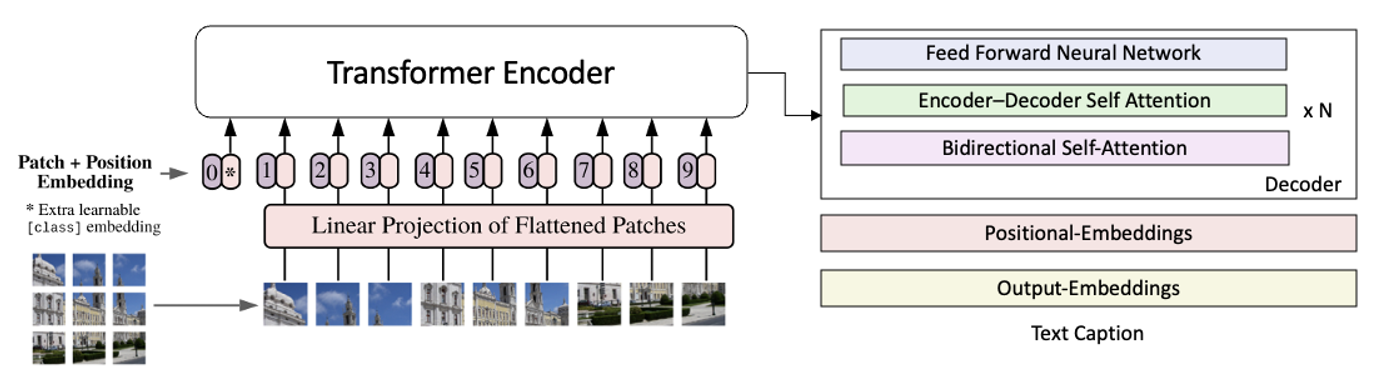

## Initial Setup and Dependency Installation
Setting up the Google Drive and installing the necessary libraries for the project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install -q datasets
!pip install accelerate -U
!pip install -q transformers
!pip install -q rouge

In [ ]:
from datasets import load_dataset


## Dataset Loading and Preview

Paths are defined, and the training, validation, and test datasets are loaded. A few images from each set are displayed to inspect the data visually.

In [ ]:
# Define the root directory containing the Flickr30k dataset
root = "/content/drive/MyDrive/MSC_PROJECT/Flickr30k/Formatted_Flickr30k/"


In [ ]:
# Load datasets for training, validation, and testing using the 'imagefolder' format
train_dataset = load_dataset('imagefolder', data_dir=root, split='train')
validation_dataset = load_dataset('imagefolder', data_dir=root, split='validation')
test_dataset = load_dataset('imagefolder', data_dir=root, split='test')


In [ ]:
# Display a sample image from the training dataset along with its caption
example_train = train_dataset[0]
image_train = example_train["image"]
width_train, height_train = image_train.size
display(image_train.resize((int(0.3 * width_train), int(0.3 * height_train))))
print("Training Caption:", example_train["text"])


In [ ]:
# Display a sample image from the test dataset along with its caption
example_test = test_dataset[0]
image_test = example_test["image"]
width_test, height_test = image_test.size
display(image_test.resize((int(0.3 * width_test), int(0.3 * height_test))))
print("Test Caption:", example_test["text"])


In [ ]:

# Display a sample image from the validation dataset along with its caption
example_validation = validation_dataset[0]
image_validation = example_validation["image"]
width_validation, height_validation = image_validation.size
display(image_validation.resize((int(0.3 * width_validation), int(0.3 * height_validation))))
print("Validation Caption:", example_validation["text"])


## Dataset Preprocessing

To make the data interpretable by the model, it undergoes preprocessing. This section focuses on converting the images and captions into a format suitable for training.


In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, ViTFeatureExtractor, VisionEncoderDecoderModel
import matplotlib.pyplot as plt


In [ ]:

class ImageCaptioningDataset(Dataset):
    """
    Custom dataset class for image captioning task.

    Args:
    - dataset: The dataset object containing images and corresponding captions.
    - feature_extractor: An initialized ViT feature extractor.
    - tokenizer: An initialized tokenizer for text captions.
    - max_target_length (int, optional): Maximum length for tokenized captions. Defaults to 128.
    """
    def __init__(self, dataset, feature_extractor, tokenizer, max_target_length=128):
        # Store the provided dataset, feature extractor, tokenizer, and maximum length
        self.dataset = dataset
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.max_length = max_target_length

    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
        - int: Number of items in the dataset.
        """
        # Return the length of the dataset
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves the item at the specified index.

        Args:
        - idx (int): Index of the item to retrieve.

        Returns:
        - dict: Dictionary containing pixel values and labels for the image-caption pair.
        """

        # Get the data at the specified index from the dataset
        item = self.dataset[idx]

        # Extract features from the image using the feature extractor
        pixel_values = self.feature_extractor(images=item["image"], return_tensors="np").pixel_values

        # Tokenize the caption text using the tokenizer
        captions = self.tokenizer(
            text=item["text"], padding="max_length", max_length=self.max_length
        ).input_ids

        # Construct and return the final encoding dictionary
        encoding = {
            "pixel_values": torch.from_numpy(pixel_values.squeeze()),  # Pixel values from the image
            "labels": torch.tensor(captions),  # Tokenized captions
        }
        return encoding



In [ ]:
# Predefined models for image encoding and text decoding
image_encoder_model = "google/vit-base-patch16-224-in21k"
text_decoder_model = "bipin/malayalam-gpt2"


In [ ]:
# Initialize the feature extractor and tokenizer
feature_extractor = AutoFeatureExtractor.from_pretrained(image_encoder_model)
tokenizer = AutoTokenizer.from_pretrained(text_decoder_model)

In [ ]:
# Create datasets for training, validation, and testing
train_data = ImageCaptioningDataset(train_dataset, feature_extractor, tokenizer)
validation_data = ImageCaptioningDataset(validation_dataset, feature_extractor, tokenizer)
test_data = ImageCaptioningDataset(test_dataset, feature_extractor, tokenizer)



In [ ]:
def print_shapes(dataset):
    """
    Prints the shapes of tensor elements in the dataset.

    Args:
    - dataset: The dataset object with processed tensor elements.
    """
    first_element = dataset[0]
    for key in first_element:
        print(f"Shape of {key} in {dataset.__class__.__name__}:", first_element[key].shape)


In [ ]:
# Display tensor shapes for debugging
print_shapes(train_data)
print_shapes(validation_data)
print_shapes(test_data)


In [ ]:
def show_processed_example(dataset, idx):
    """
    Display an image and its caption from the processed dataset.

    Args:
    - dataset: The dataset object with processed tensor elements.
    - idx (int): Index of the item to display.
    """
    processed_example = dataset[idx]
    image_tensor = processed_example["pixel_values"]
    plt.imshow(image_tensor.permute(1, 2, 0))
    plt.show()

    input_ids = processed_example["labels"].tolist()
    caption = tokenizer.decode(input_ids, skip_special_tokens=True)
    print("Caption:", caption)


In [ ]:

# Display the first image and caption from each dataset
show_processed_example(train_data, 0)
show_processed_example(validation_data, 0)
show_processed_example(test_data, 0)

## Model Setup

A VisionEncoderDecoder model, which combines ViT (for image understanding) and GPT-2 (for caption generation), is initialized.

In [ ]:
# Import the VisionEncoderDecoderModel class from the transformers library
from transformers import VisionEncoderDecoderModel

# Initialize a VisionEncoderDecoderModel by loading pre-trained encoder (for image processing) and decoder (for text generation) models.
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    image_encoder_model,  # Pre-trained model for encoding images
    text_decoder_model    # Pre-trained model for decoding text (generating captions)
)


## Evaluation Metrics Setup

Several metrics, including BLEU, METEOR, and ROUGE, are used to assess the model's performance. This section sets up the necessary functions to compute these metrics.

In [ ]:

import nltk

# Ensure that the punkt tokenizer for sentence splitting is downloaded.
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)


In [ ]:

from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu
from nltk.translate.meteor_score import meteor_score
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSeq2SeqLM
from rouge import Rouge
import numpy as np


In [ ]:

# Download WordNet which is required for METEOR score computation.
nltk.download('wordnet')

ignore_pad_token_for_loss = True


In [ ]:

def multiply_and_round(val):
    """
    Multiply the given value by 100 and round to 4 decimal places.

    Args:
    - val (float|int|list): The value(s) to be multiplied.

    Returns:
    - float|int|list: The multiplied value(s).
    """
    # If the input is a list, apply the function recursively to each element
    if isinstance(val, list):
        return [multiply_and_round(v) for v in val]
    # If the input is a float or int, multiply by 100 and round to 4 decimal places
    elif isinstance(val, float) or isinstance(val, int):
        return round(val * 100, 4)
    # If the input is neither a list nor a float/int, return it as-is
    else:
        return val


In [ ]:

def postprocess_text(preds, labels):
    """
    Post-process the predicted and ground truth texts for evaluation.

    Args:
    - preds (list): List of predicted captions.
    - labels (list): List of ground truth captions.

    Returns:
    - tuple: Post-processed predicted and ground truth captions.
    """
    # Strip any leading or trailing whitespace from the predicted captions
    preds = [pred.strip() for pred in preds]

    # Strip any leading or trailing whitespace from the ground truth captions
    labels = [label.strip() for label in labels]

    # For ROUGE-LSum metric evaluation, split the text into sentences and join them with newlines
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


In [ ]:

def compute_metrics(eval_preds):
    """
    Compute evaluation metrics for image captioning: BLEU, METEOR, and ROUGE.

    Args:
    - eval_preds (tuple): Predicted and ground truth captions.

    Returns:
    - dict: Dictionary containing BLEU, METEOR, and ROUGE scores.
    """

    # Extract predicted captions and labels from the eval_preds tuple
    preds, labels = eval_preds

    # If the predictions are in tuple format, use the first element
    if isinstance(preds, tuple):
        preds = preds[0]

    # Decode the token IDs to get the predicted captions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # If padding tokens are ignored during loss computation, replace -100 in the labels with the padding token ID
    if ignore_pad_token_for_loss:
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode the token IDs to get the ground truth captions
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Post-process the texts for evaluation
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Initialize the Rouge metric
    rouge = Rouge()

    # Compute ROUGE scores for each prediction and its corresponding ground truth
    rouge_scores = [rouge.get_scores(pred, ref[0]) for pred, ref in zip(decoded_preds, decoded_labels)]

    # Calculate the average ROUGE-1, ROUGE-2, and ROUGE-L scores
    rouge_1 = np.mean([score[0]['rouge-1']['f'] for score in rouge_scores])
    rouge_2 = np.mean([score[0]['rouge-2']['f'] for score in rouge_scores])
    rouge_l = np.mean([score[0]['rouge-l']['f'] for score in rouge_scores])

    # Tokenize the decoded predictions and labels for BLEU score computation
    tokenized_preds = [tokenizer.tokenize(pred) for pred in decoded_preds]
    tokenized_labels = [[tokenizer.tokenize(label)] for label in decoded_labels]

    # Define a smoothing function for BLEU score calculation
    smoothing = SmoothingFunction().method7

    # Compute BLEU scores with different n-gram weights
    bleu1 = corpus_bleu(tokenized_labels, tokenized_preds, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = corpus_bleu(tokenized_labels, tokenized_preds, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = corpus_bleu(tokenized_labels, tokenized_preds, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = corpus_bleu(tokenized_labels, tokenized_preds, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    # Compute METEOR scores for each prediction and its corresponding ground truth
    meteor_scores = [meteor_score([ref.split()], pred.split()) for ref, pred in zip(decoded_labels, decoded_preds)]

    # Calculate the average METEOR score
    mean_meteor = sum(meteor_scores) / len(meteor_scores)

    # Return the computed scores in a dictionary format
    return {"bleu1": bleu1, "bleu2": bleu2, "bleu3": bleu3, "bleu4": bleu4, "meteor": mean_meteor, "rouge-1": rouge_1, "rouge-2": rouge_2, "rouge-l": rouge_l}


## Training Configuration

Training arguments and configurations are set up to ensure efficient and effective model training.

In [ ]:
model.config.decoder_start_token_id = tokenizer.bos_token_id

# Configure padding token for the model
model.config.pad_token_id = tokenizer.pad_token_id

# Ensure that the vocabulary size is set to match the decoder's vocabulary size
model.config.vocab_size = model.config.decoder.vocab_size

# Configure beam search parameters for generating captions
# token indicating the end of a sequence
model.config.eos_token_id = tokenizer.sep_token_id

# maximum length of generated captions
model.config.max_length = 128

# stop generating captions early if possible
model.config.early_stopping = True


# prevent repetition of n-grams of size 3
model.config.no_repeat_ngram_size = 3

# penalize longer generated sequences
model.config.length_penalty = 2.0

# use 4 beams for beam search
model.config.num_beams = 4

# Resize token embeddings in case the pre-trained and current tokenizers don't match
model.decoder.resize_token_embeddings(len(tokenizer))

## Model Training

With all components in place, the model is now trained.

### Basic configurations
This section covers the basic configurations required for the training setup.

In [ ]:

# Specify the directory where the model checkpoints and training logs will be stored.
output_directory = "./image-captioning-output"

# Define the strategy for evaluations. In this case, evaluations are performed at regular intervals (steps).
evaluation_strategy_config = "steps"

# Specify the directory path for saving the training logs.
training_logs_directory = "/content/drive/MyDrive/Flickr30k_Models/vitgpt2/logs"

# Set the intervals for logging the training metrics and statistics.
logging_interval = 400

# Set the intervals for performing evaluations and saving the model checkpoints.
evaluation_and_save_interval = 500

# Define the strategy to determine when to save a new model checkpoint.
checkpoint_save_strategy = "steps"

### Model Behavior and Features

This section determines how the model behaves during training and what features are activated.

In [ ]:

# Whether to use the model's generate method for predictions.
use_generate_for_predictions = True

# Load the best model at the end of the training based on the evaluation metric.
load_best_model_at_training_end = True

# Define the metric that will be used to determine the best model during the training.
best_model_metric = "bleu4"

# Specify that a higher value of the metric indicates a better model.
higher_metric_is_better = True

### Training Details and Hyperparameters
This section covers the specific details and hyperparameters for the training process.

In [ ]:
# Set the learning rate for the optimizer.
optimizer_learning_rate = 1e-4

# Total number of training epochs.
total_epochs = 10

# If the gradient should be accumulated over multiple steps to effectively increase the batch size.
gradient_accumulation_steps_count = 2

# Activate mixed precision training for improved speed and reduced memory consumption.
use_mixed_precision_training = True

### Batch Sizes
This section specifies the number of examples in each training and evaluation batch.

In [ ]:
# Number of examples in each training batch.
train_batch_size = 16

# Number of examples in each evaluation batch.
eval_batch_size = 16

### Saving Behavior
This section covers configurations related to saving model checkpoints.

In [ ]:
# Set the maximum number of model checkpoints that can be saved.
max_saved_models = 3

# Determine if existing files in the output directory should be overwritten.
overwrite_existing_files = True

### Setting Training Arguments
This section initializes the training arguments using the previously defined configurations.

In [ ]:

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback

training_args = Seq2SeqTrainingArguments(
    output_dir=output_directory,
    evaluation_strategy=evaluation_strategy_config,
    logging_dir=training_logs_directory,
    logging_steps=logging_interval,
    eval_steps=evaluation_and_save_interval,
    save_strategy=checkpoint_save_strategy,
    predict_with_generate=use_generate_for_predictions,
    load_best_model_at_end=load_best_model_at_training_end,
    metric_for_best_model=best_model_metric,
    greater_is_better=higher_metric_is_better,
    learning_rate=optimizer_learning_rate,
    num_train_epochs=total_epochs,
    gradient_accumulation_steps=gradient_accumulation_steps_count,
    fp16=use_mixed_precision_training,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=eval_batch_size,
    save_steps=evaluation_and_save_interval,
    save_total_limit=max_saved_models,
    overwrite_output_dir=overwrite_existing_files
)

### Initializing the Seq2Seq Trainer
The section below sets up the Seq2SeqTrainer which will be responsible for training and evaluating the sequence-to-sequence model.
The transformers library provides a Seq2SeqTrainer class, which is designed specifically for training sequence-to-sequence models, such as our image captioning model. This trainer class simplifies the training and evaluation process, abstracting away many of the complex steps involved in training deep learning models.

In [ ]:
# Import the default data collator from the `transformers` library.
# The data collator is responsible for forming batches from the dataset.
from transformers import default_data_collator

In [ ]:
# Create a Seq2SeqTrainer instance to facilitate training and evaluation of sequence-to-sequence models.
trainer = Seq2SeqTrainer(

    # The pre-trained or initialized model to be trained further.
    model=model,

    # Tokenizer (or feature extractor in case of vision tasks) to process data.
    tokenizer=feature_extractor,

    # Arguments and configurations for the training process.
    args=training_args,

    # Function to compute evaluation metrics during validation.
    compute_metrics=compute_metrics,

    # The dataset used for training.
    train_dataset=train_data,

    # The dataset used for validation.
    eval_dataset=validation_data,

    # Collates batches from the dataset.
    data_collator=default_data_collator,

    # Callback for early stopping if validation score doesn't improve.
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)


In [ ]:
def get_latest_checkpoint(output_dir):
    """
    Retrieve the latest checkpoint from the specified directory.

    Args:
        output_dir (str): The directory in which to search for checkpoints.

    Returns:
        str or None: The path to the latest checkpoint if found, otherwise None.
    """

    # List all the directories in the output_dir that contain "checkpoint-"
    # and are actual directories.
    checkpoints = [d for d in os.listdir(output_dir) if "checkpoint-" in d and os.path.isdir(os.path.join(output_dir, d))]

    # If there are any checkpoints, return the one with the highest index (latest checkpoint).
    if checkpoints:
        return os.path.join(output_dir, max(checkpoints, key=lambda x: int(x.split("-")[-1])))

    # If no checkpoints are found, return None.
    else:
        return None


In [ ]:
latest_checkpoint = get_latest_checkpoint(training_args.output_dir)
print(f"Latest checkpoint found: {latest_checkpoint}")

In [ ]:
# Train the model using the trainer
# If a checkpoint is found, resume from that checkpoint
trainer.train(resume_from_checkpoint=latest_checkpoint)

## TensorBoard Visualization

Training dynamics are visualized using TensorBoard for a clearer understanding of the training process.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

## Model Evaluation and Saving

After training, the trained model is saved for potential future applications.

In [ ]:

path = "/content/drive/MyDrive/Flickr30k_Models/vitgptlr1e-4epochs10"

model.save_pretrained(path)